In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
import pandas as pd
from scipy.stats import norm
from atlasreader import create_output
import sklearn

import nilearn
from nilearn.plotting import plot_glass_brain, plot_stat_map
from nilearn.image import new_img_like, math_img, threshold_img, concat_imgs
from nilearn import plotting
from nilearn.glm import threshold_stats_img
from nilearn.glm.second_level import SecondLevelModel

In [28]:
f = open('../FaceWordData/WordFace_searchlight_1.pkl', 'rb')
searchlight = pickle.load(f)
f.close()
print(searchlight)

SearchLight(cv=10, estimator=LinearSVC(dual='auto', max_iter=2000),
            mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f38a85720b0>,
            n_jobs=-1,
            process_mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f38a79a7910>,
            radius=5, verbose=10)


/work/neuro_5/neuro_env/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LinearSVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [29]:
mask_wb_filename='../FaceWordData/BIDS/derivatives/sub-0054/anat/sub-0054_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'

searchlight_img = new_img_like(mask_wb_filename, searchlight.scores_)
print(searchlight_img.shape)

(193, 235, 198)


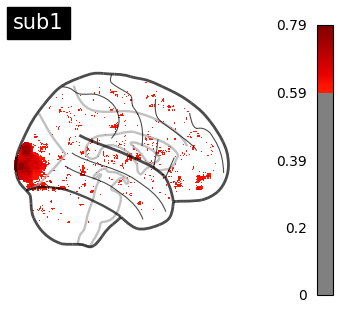

In [30]:
plot_glass_brain(searchlight_img, cmap='jet',colorbar=True, threshold=0.6,
                              title=('sub1'),
                              plot_abs=False, display_mode='x')

   
#plt.suptitle('Classification accuracy (unc Acc>0.6)')
plt.show()

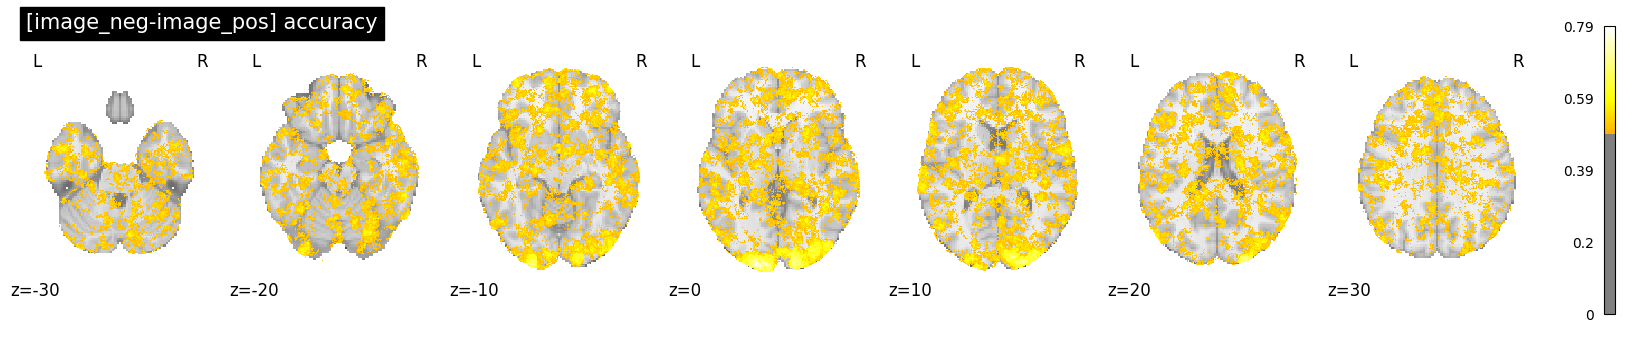

In [31]:
plot_stat_map(searchlight_img, cmap='cold_hot',threshold=0.5, cut_coords=[-30,-20,-10,0,10,20,30],
              display_mode='z',  black_bg=False,
              title='[image_neg-image_pos] accuracy')
plt.show()

In [32]:
N_par=21
searchlight_all= np.empty((N_par, 0)).tolist()
searchlight_all=[]
searchlight_demean=[]
conditions_label_all= np.empty((N_par, 0)).tolist()

for i in range(0,N_par):
    text = "Loading file %d\n" % (i+1)
    print(text)
    file_name='../FaceWordData/WordFace_searchlight_'+str(i)+'.pkl'
    f = open(file_name, 'rb')
    searchlight = pickle.load(f)
    searchlight_img = new_img_like(mask_wb_filename, searchlight.scores_)
    searchlight_all.append(searchlight_img)
    searchlight_demean.append(math_img("(img1-0.5)*img2",img1=searchlight_img,img2=mask_wb_filename))
    
    #searchlight_all[i]=searchlight
    f.close()


print(searchlight_all[1])

Loading file 1

Loading file 2

Loading file 3

Loading file 4

Loading file 5

Loading file 6

Loading file 7

Loading file 8

Loading file 9

Loading file 10

Loading file 11

Loading file 12

Loading file 13

Loading file 14

Loading file 15

Loading file 16

Loading file 17

Loading file 18

Loading file 19

Loading file 20

Loading file 21


<class 'nibabel.nifti1.Nifti1Image'>
data shape (193, 235, 198)
affine:
[[   1.       0.       0.     -96.   ]
 [   0.       0.977    0.    -132.   ]
 [   0.       0.       0.977  -78.   ]
 [   0.       0.       0.       1.   ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 193 235 198   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0

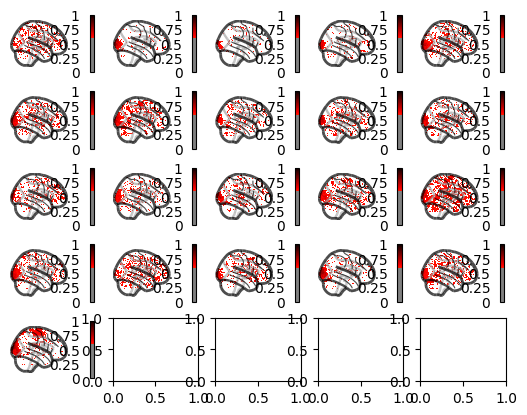

In [33]:
#subjects = data["ext_vars"]["participant_id"].tolist()
fig, axes = plt.subplots(nrows=5, ncols=5)
for cidx, map in enumerate(searchlight_all):
    plotting.plot_glass_brain(
        map,
        colorbar=True,
        threshold=0.6,
        vmin=0.5,
        vmax=1,
        title=None,
        axes=axes[int(cidx / 5), int(cidx % 5)],
        plot_abs=False,
        display_mode="x",
    )
plt.show()

In [34]:
#Concatenate beta maps
searchlight_conc=concat_imgs(searchlight_all)
# Make a mean image
searchlight_mean=mean_img(searchlight_conc)
#Concatenate baseline corrected maps
searchlight_conc_de=concat_imgs(searchlight_demean)
# Make a mean of the baseline-corrected image
searchlight_mean_demean=mean_img(searchlight_conc_de)

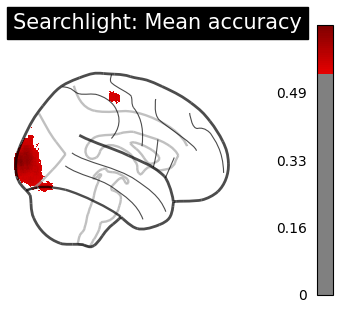

In [35]:
plot_glass_brain(searchlight_mean, cmap='jet',colorbar=True, threshold=0.55,
                              title=('Searchlight: Mean accuracy'),
                              plot_abs=False, display_mode='x')

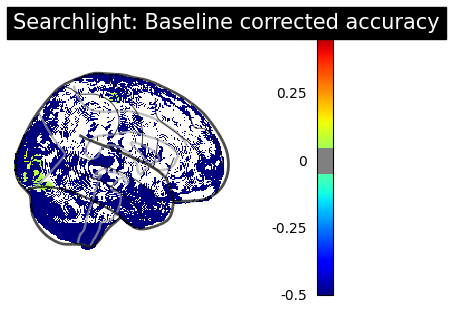

In [36]:
plot_glass_brain(searchlight_mean_demean, cmap='jet',colorbar=True, threshold=0.05,vmin=0,
                              title=('Searchlight: Baseline corrected accuracy'),
                              plot_abs=False, display_mode='x')

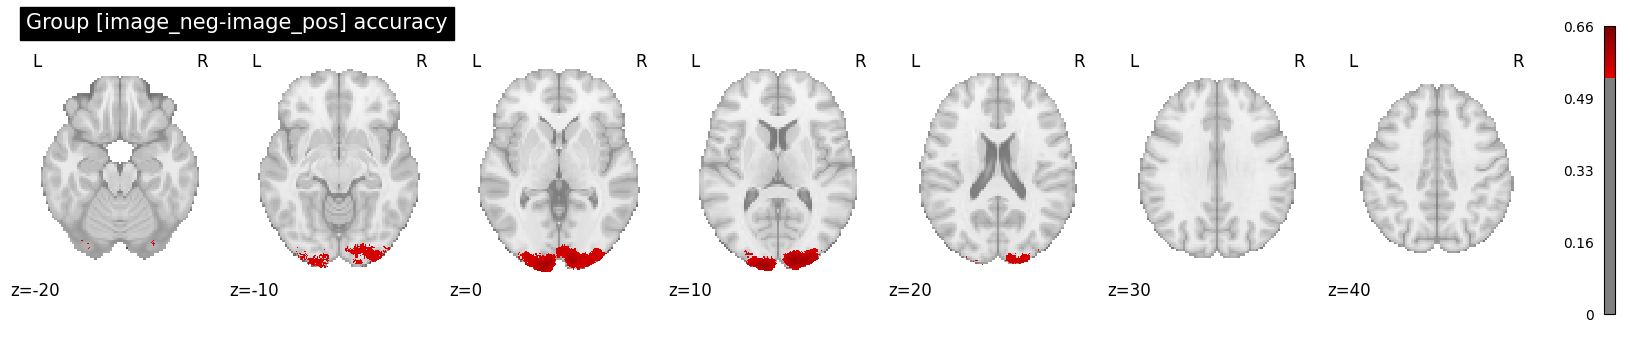

In [37]:
plot_stat_map(searchlight_mean, cmap='jet',threshold=0.55, cut_coords=[-20,-10,0,10,20,30,40],
              display_mode='z',  black_bg=False,
              title='Group [image_neg-image_pos] accuracy')
plt.show()

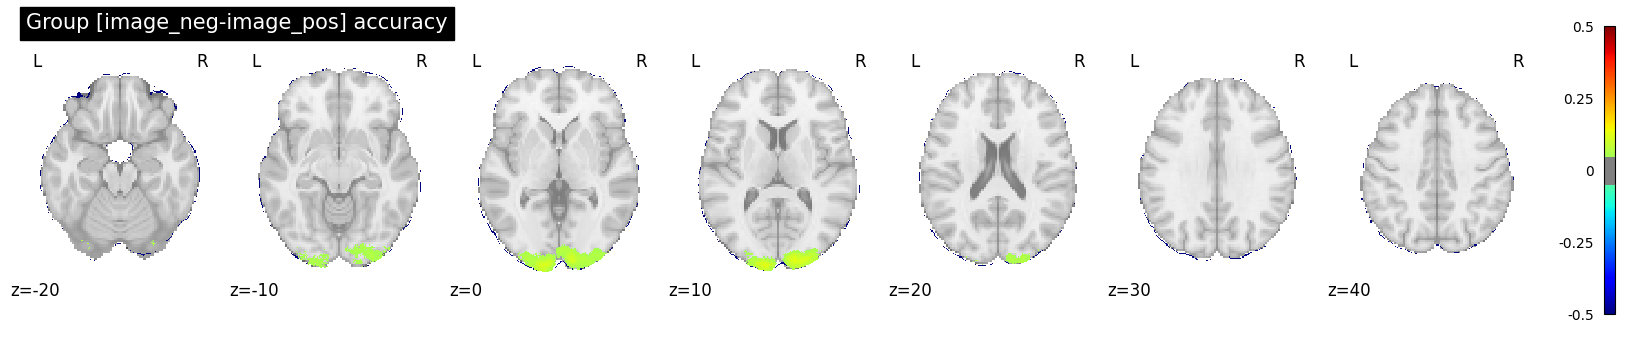

In [38]:
plot_stat_map(searchlight_mean_demean, cmap='jet',threshold=0.05, cut_coords=[-20,-10,0,10,20,30,40],
              display_mode='z',  black_bg=False,
              title='Group [image_neg-image_pos] accuracy')
plt.show()

In [39]:
second_level_input = searchlight_demean
design_matrix = pd.DataFrame(
    [1] * len(second_level_input),
    columns=["intercept"],
)

second_level_model = SecondLevelModel(smoothing_fwhm=6.0, n_jobs=2)
second_level_model = second_level_model.fit(
    second_level_input,
    design_matrix=design_matrix,
)

z_map = second_level_model.compute_contrast(
    second_level_contrast="intercept",
    output_type="z_score",
)

/work/neuro_5/neuro_env/lib/python3.10/site-packages/nilearn/glm/_utils.py:346: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


In [40]:
p_val = 0.001
p001_unc = norm.isf(p_val)
print(f"The p<0.001 threshold is {p001_unc:.3g}")

thresholded_map2, threshold2 = threshold_stats_img(
    z_map, alpha=0.05, height_control="fdr"
)
print(f"The FDR=.05 threshold is {threshold2:.3g}")

thresholded_map3, threshold3 = threshold_stats_img(
    z_map, alpha=0.05, height_control="bonferroni"
)
print(f"The p<.05 Bonferroni-corrected threshold is {threshold3:.3g}")

#Remove negative effects from image (they are meaningless)
z_map_disp=threshold_img(
    z_map,
    threshold=0,
    two_sided=False,
)

The p<0.001 threshold is 3.09
The FDR=.05 threshold is 2.61
The p<.05 Bonferroni-corrected threshold is 5.57


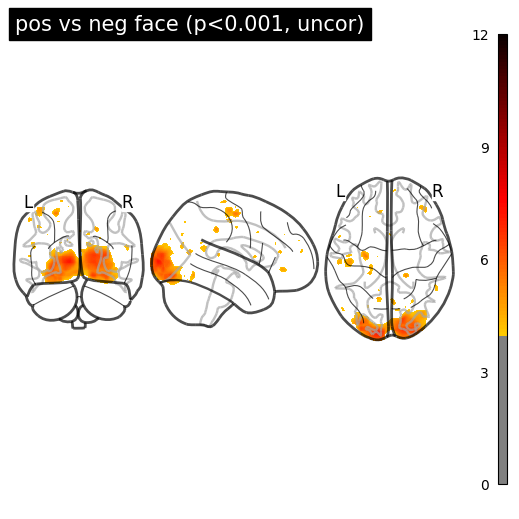

In [41]:
display = plotting.plot_glass_brain(
    z_map_disp,
    threshold=4,
    vmin=0,
    vmax=12,
    colorbar=True,
    symmetric_cbar=False,
    #display_mode="x",
    plot_abs=False,
    title="pos vs neg face (p<0.001, uncor)",
    figure=plt.figure(figsize=(5, 5)),
)
plotting.show()


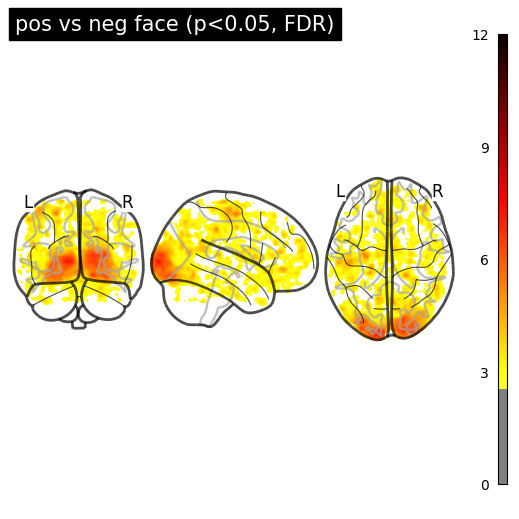

In [42]:
display = plotting.plot_glass_brain(
    z_map_disp,
    threshold=threshold2,
    vmin=0,
    vmax=12,
    colorbar=True,
    symmetric_cbar=False,
    #display_mode="x",
    plot_abs=False,
    title="pos vs neg face (p<0.05, FDR)",
    figure=plt.figure(figsize=(5, 5)),
)
plotting.show()


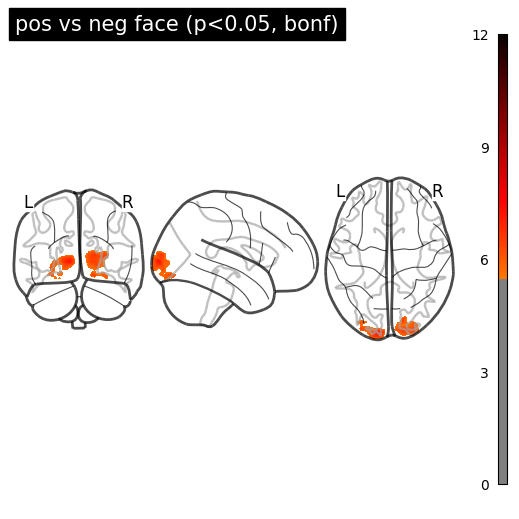

In [43]:
display = plotting.plot_glass_brain(
    z_map_disp,
    threshold=threshold3,
    vmin=0,
    vmax=12,
    colorbar=True,
    symmetric_cbar=False,
    #display_mode="x",
    plot_abs=False,
    title="pos vs neg face (p<0.05, bonf)",
    figure=plt.figure(figsize=(5, 5)),
)
plotting.show()

In [44]:
create_output(thresholded_map3, voxel_thresh=.99, cluster_extent=2, direction='pos', outdir='../atlasreader')
